In [1]:
!pip3 install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error # accuarcy metrics
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

# Data Visualization

In [3]:
# read data set
df = pd.read_csv("https://raw.githubusercontent.com/Kande2011/TimeSeriesAnalysisOfCOVID19/data_preprocessing/DataSets/us-counties-2020.csv")
df.head()


,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


In [4]:
# Remove unnecessary columns
df = df.drop(['geoid','county','cases_avg_per_100k','cases_avg_per_100k','deaths_avg_per_100k'], axis=1)

In [5]:
# Simplify column names
df.columns = ['date',  'state', 'deaths', 'cases_avg', 'cases', 'deaths_avg']
# Specify target and feature columns
targets = ['cases']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,state,deaths,cases_avg,cases,deaths_avg
0,2020-01-21,Washington,1,0.14,0,0.0
1,2020-01-22,Washington,0,0.14,0,0.0
2,2020-01-23,Washington,0,0.14,0,0.0
3,2020-01-24,Washington,0,0.14,0,0.0
4,2020-01-24,Illinois,1,0.14,0,0.0


In [6]:
# Change date format to date timestamp
from datetime import datetime, date 
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,state,deaths,cases_avg,cases,deaths_avg
0,2020-01-21 00:00:00,Washington,1,0.140000,0,0.000000
1,2020-01-22 00:00:00,Washington,0,0.140000,0,0.000000
2,2020-01-23 00:00:00,Washington,0,0.140000,0,0.000000
3,2020-01-24 00:00:00,Washington,0,0.140000,0,0.000000
4,2020-01-24 00:00:00,Illinois,1,0.140000,0,0.000000


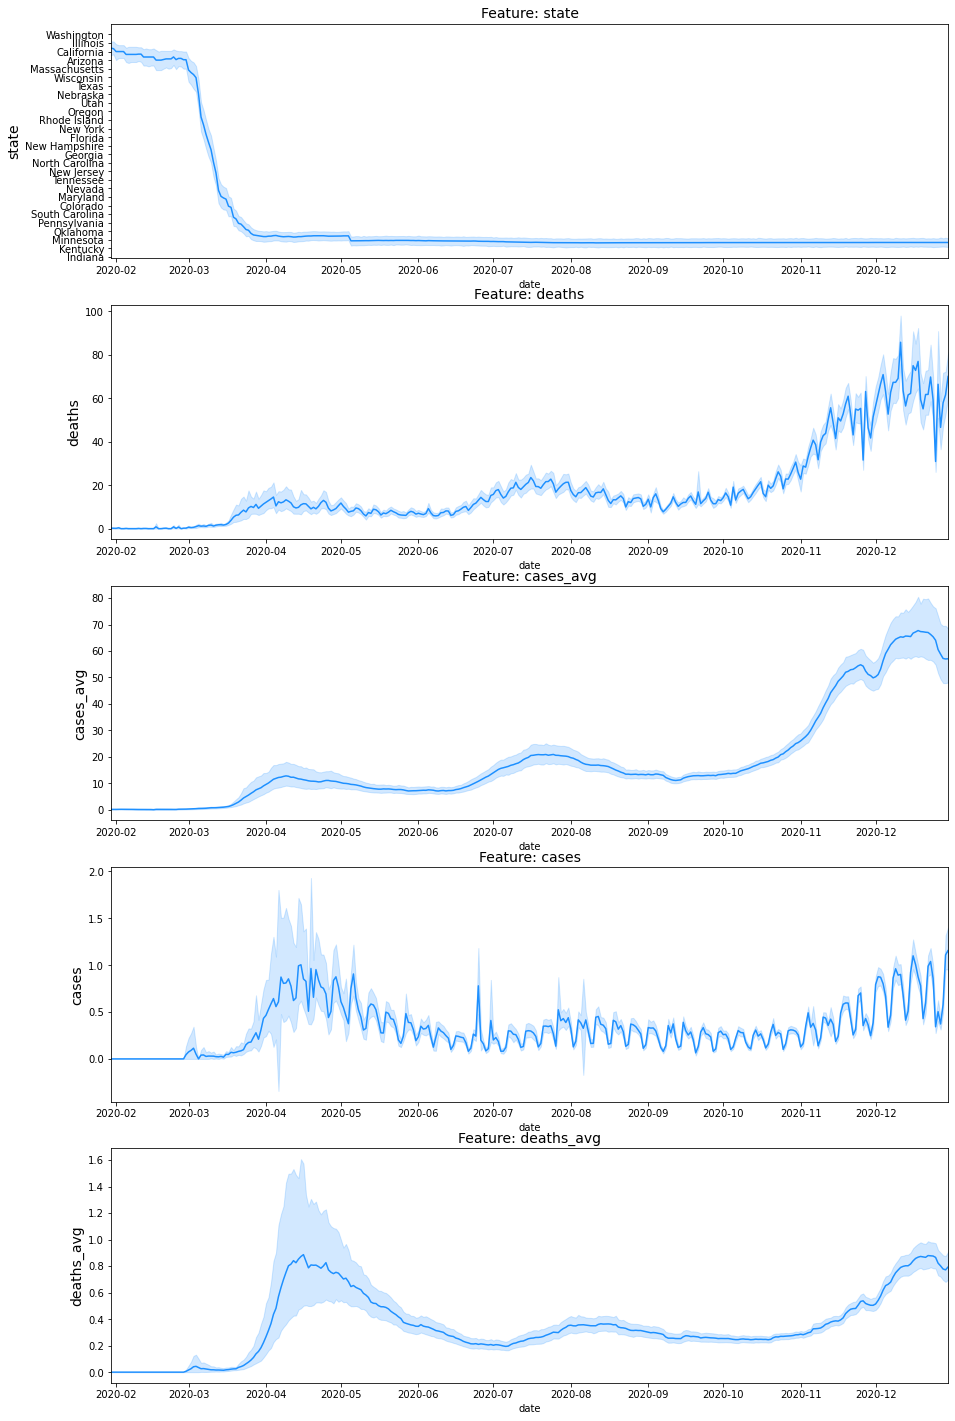

In [7]:
# plot feature and target columns for visualization
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2020, 1, 30), date(2020, 12, 30)])

# Date Preprocessing

## Sorting and Equidistant Data 

In [8]:
# Sort dataset by date column
df = df.sort_values(by='date')
# Check date column and time intervals 
# Add time interval as 'delta column' for visualization
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

,date,delta
0,2020-01-21,NaT
1,2020-01-22,1 days
2,2020-01-23,1 days
3,2020-01-24,1 days
4,2020-01-24,0 days


In [9]:
# number of distict rows and total rows 
df['delta'].sum(), df['delta'].count()

(Timedelta('345 days 00:00:00'), 889997)

## Handle misssing data

In [10]:
# drop delta column
df = df.drop('delta', axis=1)
# Check for missing values
df.isna().sum()

date          0
state         0
deaths        0
cases_avg     0
cases         0
deaths_avg    0
dtype: int64

no missing values, so no operations required

## Data Resampling

In [11]:
# To smooth the data, downsample data from daily to weekly
downsample = df[['date','state','deaths', 'cases_avg', 'cases', 'deaths_avg']].resample('7D', on='date').mean().reset_index(drop=False)
df = downsample.copy()

## Stationarity

###Visual Check

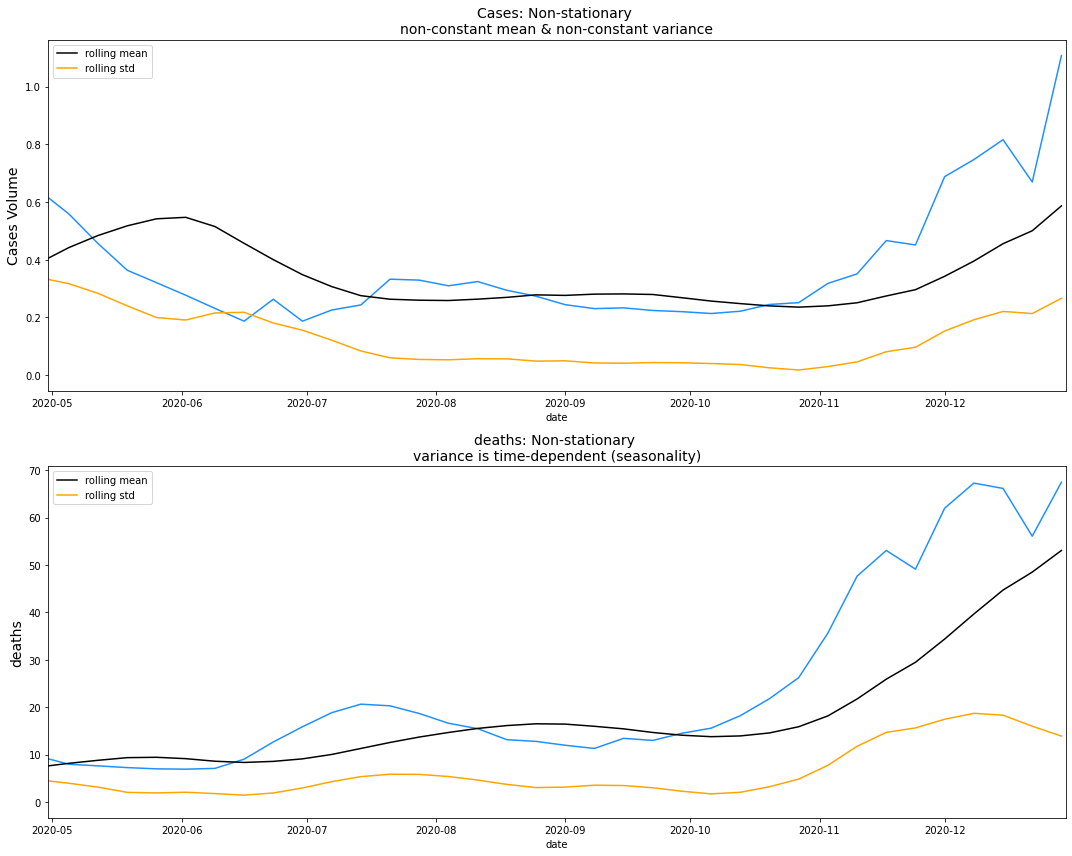

In [12]:
# Visual check for stationarity
rolling_window = 10
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['cases'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['cases'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['cases'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Cases: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Cases Volume', fontsize=14)
ax[0].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

sns.lineplot(x=df['date'], y=df['deaths'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['deaths'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['deaths'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('deaths: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='deaths', fontsize=14)
ax[1].set_xlim([date(2020, 4, 30), date(2020, 12, 30)])

plt.tight_layout()
plt.show()

### ADF

In [13]:
# Output of ADF function for target column
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['cases'].values)
result

(-0.8551081170344931,
 0.8023964299889248,
 5,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 -71.78398307571935)

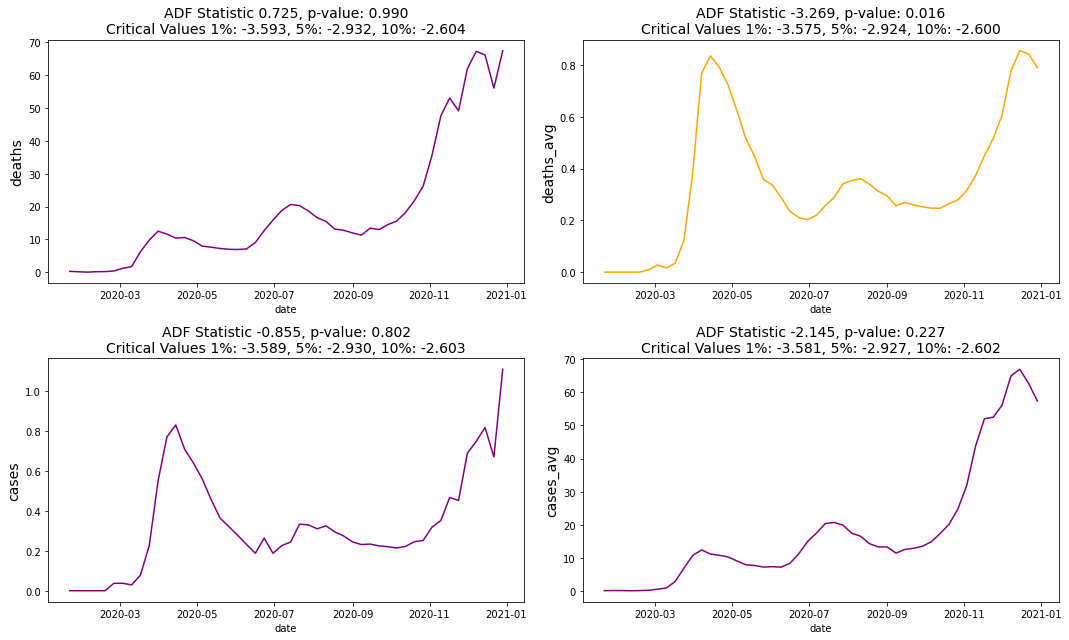

In [14]:
# Visualize ADF results for all the columns in the dataset
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]

    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    # Check for stationarity using p value and ADF statistic
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' # Stationary
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange' # Statinary
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red' # Stationary
    else:
        linecolor = 'purple' # Non-stationary
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['deaths'].values, 'deaths', ax[0, 0])
visualize_adfuller_results(df['cases'].values, 'cases', ax[1, 0])
visualize_adfuller_results(df['deaths_avg'].values, 'deaths_avg', ax[0, 1])
visualize_adfuller_results(df['cases_avg'].values, 'cases_avg', ax[1, 1])
plt.tight_layout()
plt.show()


As p-value>0.05 means non-stationary and 'Purple' lines indicates this in the graphs, most of our data is not stationary so use differencing to make it stationary.

### Differencing

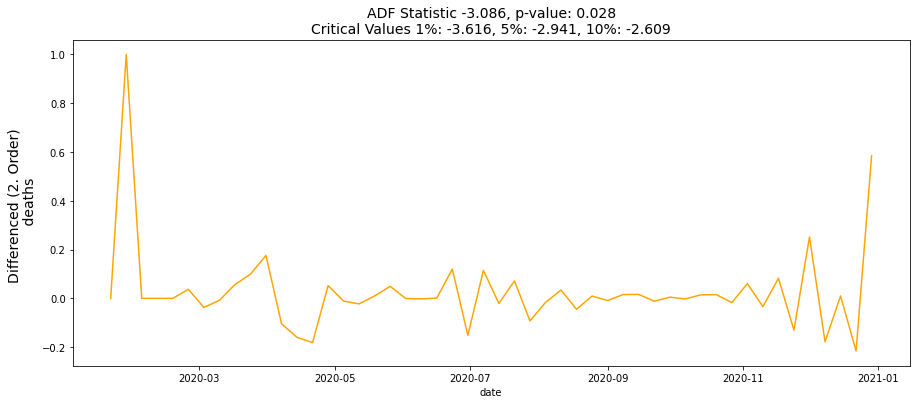

In [15]:
# First Order Differencing
ts_diff = np.diff(df['cases'],n=2)
df['cases_diff_1'] = np.append([0,1], ts_diff)

# Plot column after differencing and
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
# Visualize ADF results
visualize_adfuller_results(df['cases_diff_1'], 'Differenced (2. Order) \n deaths', ax)

p-value = 0.046(< 0.05) indicates the data has become stationary.

# Feature engineering

###Time Series Decomposition

In [16]:
# Check for trends and seasonality for more analysis of the time series used
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [ 'cases','deaths','deaths_avg','cases_avg']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=25, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

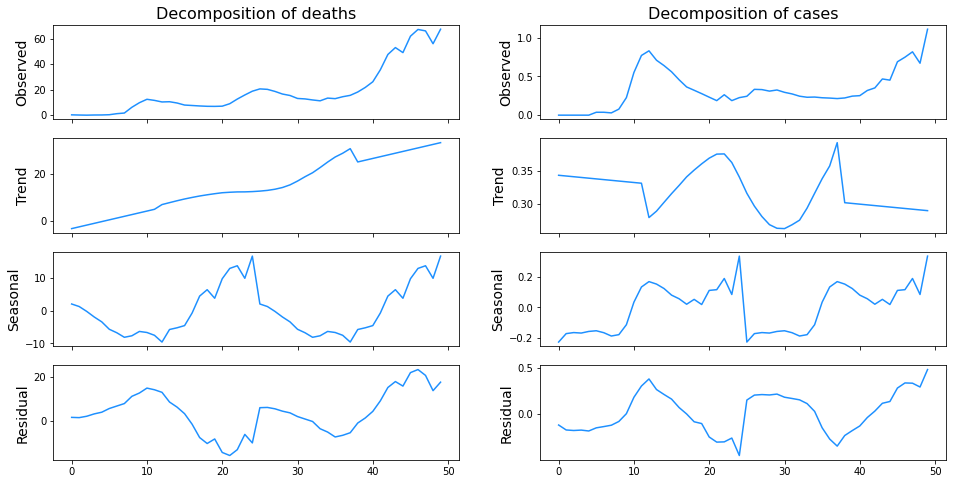

In [17]:
# Visualize trends and seasonality in our data
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['deaths', 'cases']):
    
    res = seasonal_decompose(df[column], freq=25, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

### Lag Calculation

In [18]:
# Shift each feature for correlating of lag terms with original
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

##Exploratory Data Analysis

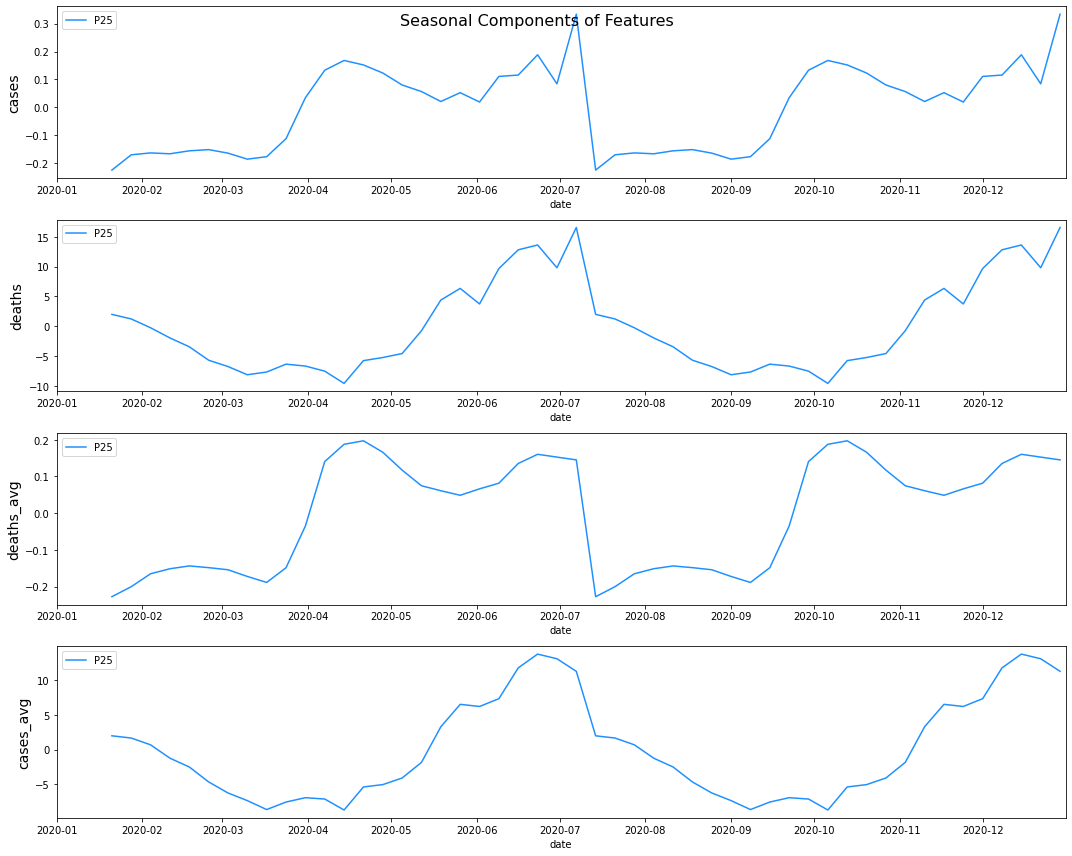

In [19]:
# Visualize seasionality of the features
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2020, 12, 31)])
    
plt.tight_layout()
plt.show()

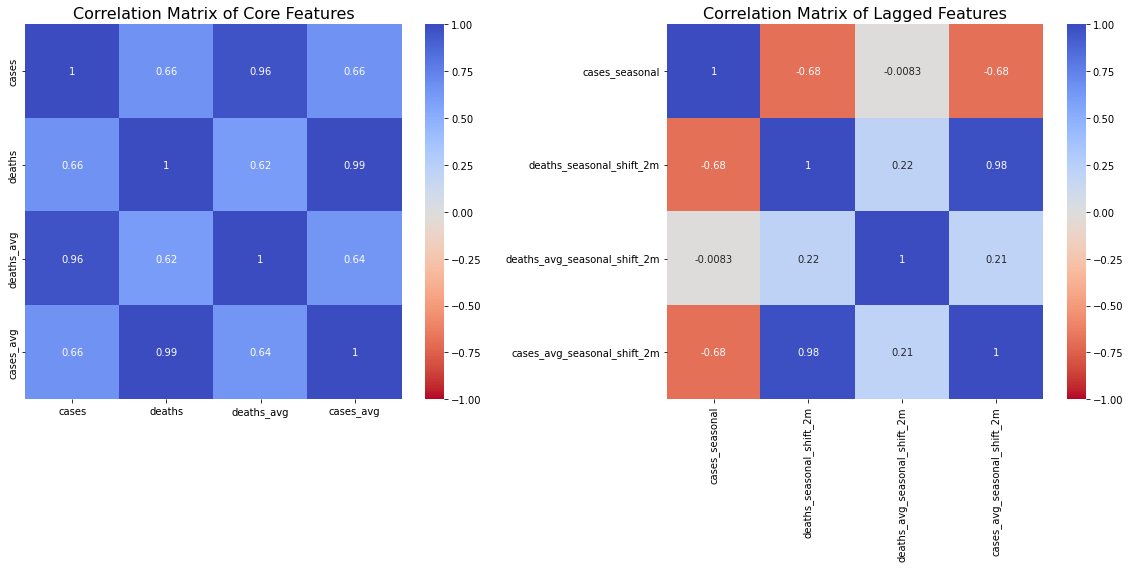

In [20]:
# Visualize and compare correlation betwwen original and lagged features
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'cases_seasonal',         
    'deaths_seasonal_shift_2m',
    'deaths_avg_seasonal_shift_2m', 
    'cases_avg_seasonal_shift_2m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

Auto-correlation of the features in the shifted(lagged) ones is less than the original ones.

## Autocorrelation Analysis

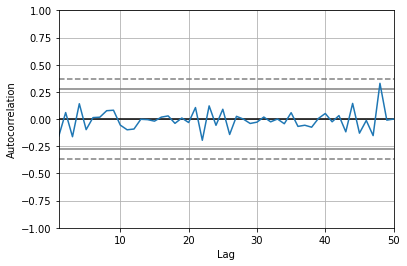

In [21]:
# plot autocorrealtion funtion of differenced column
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['cases_diff_1'])
plt.show()

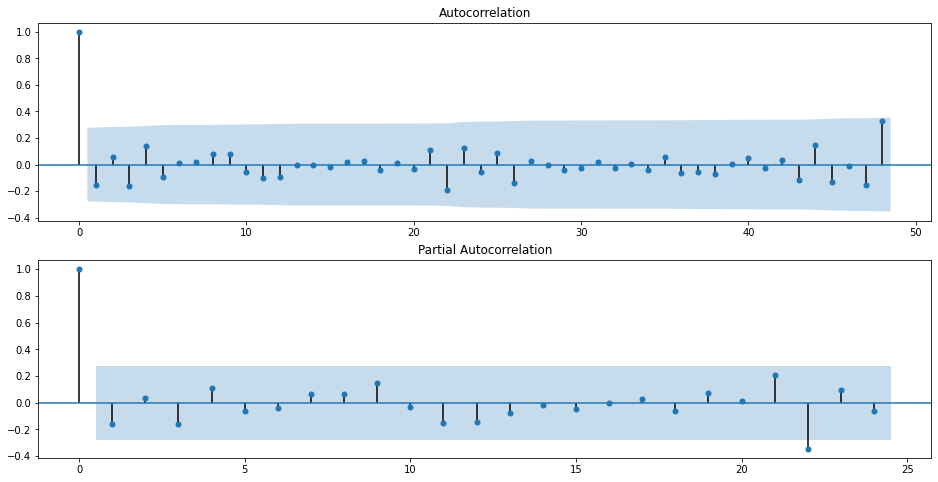

In [22]:
# plot Autocorrelation and Partial autocorrelation of the differenced data column
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['cases_diff_1'], lags=48, ax=ax[0])
plot_pacf(df['cases_diff_1'], lags=24, ax=ax[1])

plt.show()

#Modelling

##Train-Test Split

In [23]:
# split data into training and testing dataset for visualization
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['cases']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

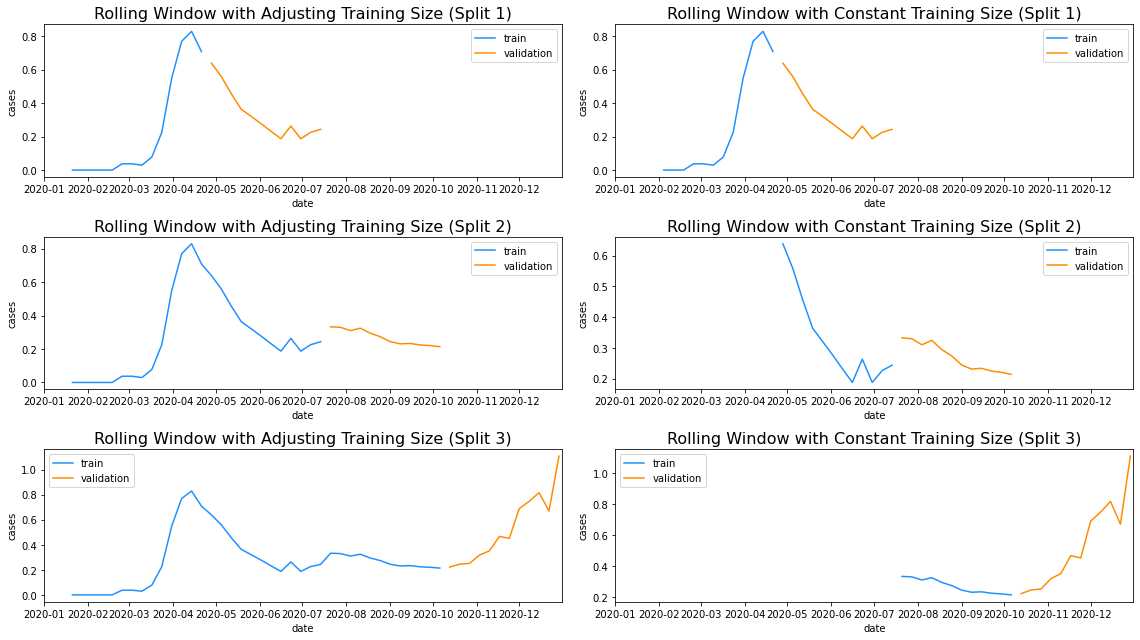

In [24]:
# Visualize difference between rolling and constant Training size
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2020, 12, 31)])
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2020, 12, 31)])
    
plt.tight_layout()
plt.show()

In [25]:
# Split data into training and testing samples for our models
train_size = 25
test_size = len(df) - train_size

univariate_df = df[['date', 'cases']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])


## ARIMA

In [26]:
from statsmodels.tsa.arima_model import ARIMA

# Train and Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()
model_fit.save('Forecast.h5')

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(25)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.18708875032259725


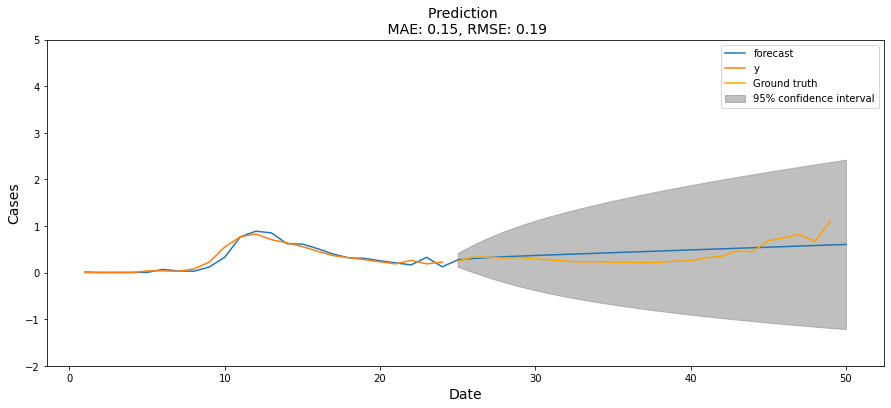

In [27]:
# Visualize original data against predicted data
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 50, ax=ax)
fig = sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Cases', fontsize=14)

ax.set_ylim(-2, 5)
plt.show()
fig.figure.savefig('graph.jpg')

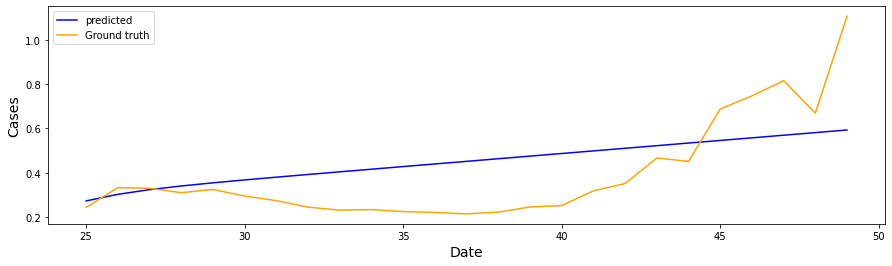

In [28]:
# Plot test and predicted data set
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_test.index, y=y_pred, ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Cases', fontsize=14)

plt.show()

# LSTM

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [30]:
# transform input features to scaler
scaler.fit(x_train)
scaled_train_data = scaler.transform(x_train)
scaled_test_data = scaler.transform(x_test)

In [31]:
# generate time series
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_test_data, length=n_input, batch_size=1)

In [32]:
# load the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit the model
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
13/13 [==============================] - 1s 6ms/step - loss: 2.9419
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 2.4563
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 1.9591
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 1.0054
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.3532
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1882
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1793
Epoch 8/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1627
Epoch 9/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1482
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1474
Epoch 11/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1178
Epoch 12/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1249
Epoch 13/20
13/13 [==============================

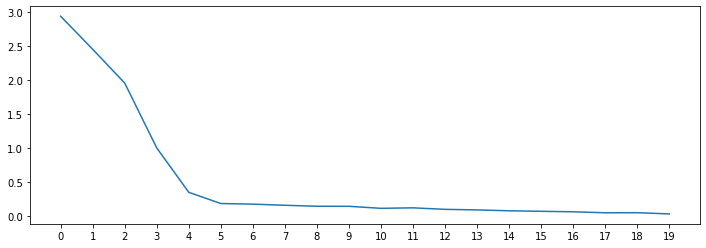

In [34]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [35]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(y_train)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [36]:
lstm_predictions_scaled

[array([2.4140139], dtype=float32),
 array([2.862537], dtype=float32),
 array([3.5222902], dtype=float32),
 array([4.5302052], dtype=float32),
 array([6.1154165], dtype=float32),
 array([8.687351], dtype=float32),
 array([12.999279], dtype=float32),
 array([20.476864], dtype=float32),
 array([33.46495], dtype=float32),
 array([55.498795], dtype=float32),
 array([93.14489], dtype=float32),
 array([156.60971], dtype=float32),
 array([263.88977], dtype=float32),
 array([436.91437], dtype=float32),
 array([722.66376], dtype=float32),
 array([1191.9607], dtype=float32),
 array([1949.8175], dtype=float32),
 array([3121.3687], dtype=float32),
 array([4272.1934], dtype=float32),
 array([3234.1445], dtype=float32),
 array([4004.939], dtype=float32),
 array([7078.133], dtype=float32),
 array([6508.1978], dtype=float32),
 array([4980.053], dtype=float32),
 array([1337.5981], dtype=float32)]

In [37]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [38]:
lstm_predictions

array([[1.61460469e+18],
       [1.62111510e+18],
       [1.63069155e+18],
       [1.64532164e+18],
       [1.66833129e+18],
       [1.70566344e+18],
       [1.76825193e+18],
       [1.87679057e+18],
       [2.06531525e+18],
       [2.38514090e+18],
       [2.93158150e+18],
       [3.85278607e+18],
       [5.40997760e+18],
       [7.92146423e+18],
       [1.20691738e+19],
       [1.88811127e+19],
       [2.98815558e+19],
       [4.68868551e+19],
       [6.35913058e+19],
       [4.85238195e+19],
       [5.97120549e+19],
       [1.04320078e+20],
       [9.60473568e+19],
       [7.38660333e+19],
       [2.09950694e+19]])